# TMDB Project: Step-by-Step Data Pipeline

This notebook demonstrates the TMDB data analysis pipeline in a granular, step-by-step manner. We will call individual methods from our modular `DataCleaner`, `MovieAnalyzer`, and `DataVisualizer` to transparently show how raw data is transformed into a clean dataset ready for analysis.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from IPython.display import Image, display
from dotenv import load_dotenv
from models import MovieExtractor, DataCleaner, MovieAnalyzer, DataVisualizer

# Load environment variables
load_dotenv()
api_key = os.getenv("api_key")

if not api_key:
    print("Error: API Key not found! Please check your .env file.")

## 1. Data Extraction

We first fetch the raw data from the TMDB API using our `MovieExtractor` model.

In [2]:
# Define parameters
movie_ids = [0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428,
             168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445,
             321612, 260513]
raw_data_path = 'data/raw/movies_data.csv'

# Run Extraction
extractor = MovieExtractor(api_key)
df_raw = extractor.run(movie_ids, raw_data_path)
print(f"Fetched {len(df_raw)} movies.")
df_raw.head()

Fetching data for 19 movies...
Fetching data for movie ID: 0
Error fetching movie 0: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=abd7ddd463d259672c9b4720124aaaac&append_to_response=credits. Retrying in 5 seconds...
Failed to fetch movie 0 after retry: 404 Client Error: Not Found for url: https://api.themoviedb.org/3/movie/0?api_key=abd7ddd463d259672c9b4720124aaaac&append_to_response=credits
Failed to fetch data for movie with ID: 0
Fetching data for movie ID: 597
Fetching data for movie ID: 12445
Fetching data for movie ID: 19995
Fetching data for movie ID: 24428
Fetching data for movie ID: 99861
Fetching data for movie ID: 109445
Fetching data for movie ID: 135397
Fetching data for movie ID: 140607
Fetching data for movie ID: 168259
Fetching data for movie ID: 181808
Fetching data for movie ID: 260513
Fetching data for movie ID: 284054
Fetching data for movie ID: 299534
Fetching data for movie ID: 299536
Fetching data for movie ID: 321612
Fetching

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,origin_country,original_language,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,credits
0,False,/xnHVX37XZEp33hhCbYlQFq7ux1J.jpg,None,200000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.paramountmovies.com/movies/titanic,597,tt0120338,[US],en,...,2264162353,194,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Nothing on earth could come between them.,Titanic,False,7.900,26704,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
1,False,/cbcpDn6XJaIGoOil1bKuskU8ds4.jpg,"{'id': 1241, 'name': 'Harry Potter Collection'...",125000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",https://www.warnerbros.com/movies/harry-potter...,12445,tt1201607,[GB],en,...,1341511219,130,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,It all ends.,Harry Potter and the Deathly Hallows: Part 2,False,8.081,21613,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
2,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.avatar.com/movies/avatar,19995,tt0499549,[US],en,...,2923706026,162,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Enter the world of Pandora.,Avatar,False,7.600,33340,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
3,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.marvel.com/movies/the-avengers,24428,tt0848228,[US],en,...,1518815515,143,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some assembly required.,The Avengers,False,7.921,35437,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."
4,False,/kIBK5SKwgqIIuRKhhWrJn3XkbPq.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",235000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",https://www.marvel.com/movies/avengers-age-of-...,99861,tt2395427,[US],en,...,1405403694,141,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A new age has come.,Avengers: Age of Ultron,False,7.270,24055,"{'cast': [{'adult': False, 'gender': 2, 'id': ..."


## 2. Data Cleaning (Step-by-Step)

Instead of running a single `clean()` function, we will perform the cleaning in detailed stages.

In [3]:
# Initialize the cleaner and load data manually if needed (or just use df_raw from above)
cleaner = DataCleaner()
df = df_raw.copy()
print("Initial columns:", df.columns.tolist())

Initial columns: ['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'origin_country', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'credits']


### Step 2.1: Drop Irrelevant Columns
We remove columns like `adult`, `homepage`, `video`, etc. that are not needed for our analysis.

In [4]:
df = cleaner.drop_irrelevant_columns(df)
print("Columns after dropping irrelevant:", df.columns.tolist())

dropping irrelevant columns...
Columns after dropping irrelevant: ['backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'id', 'origin_country', 'original_language', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'vote_average', 'vote_count', 'credits']


### Step 2.2: Flatten JSON Columns
Columns like `genres`, `production_companies`, and `belongs_to_collection` contain JSON strings. We flatten them into readable pipe-separated strings.

In [5]:
df = cleaner.flatten_json_columns(df)
df[['title', 'genres', 'collection_name']].head()

Flattening JSON columns...


,title,genres,collection_name
0,Titanic,Drama|Romance,NaN
1,Harry Potter and the Deathly Hallows: Part 2,Adventure|Fantasy,Harry Potter Collection
2,Avatar,Action|Adventure|Fantasy|Science Fiction,Avatar Collection
3,The Avengers,Science Fiction|Action|Adventure,The Avengers Collection
4,Avengers: Age of Ultron,Action|Adventure|Science Fiction,The Avengers Collection


### Step 2.3: Convert DataTypes & Basic Filtering
We convert dates, numeric columns, and filter only for movies with `status='Released'`.

In [6]:
df = cleaner.convert_datatypes(df)
df.dtypes

Converting datatypes and filtering status...


backdrop_path                       str
belongs_to_collection            object
budget                            int64
genres                              str
id                                int64
origin_country                   object
original_language                   str
overview                            str
popularity                      float64
poster_path                         str
production_companies                str
production_countries                str
release_date             datetime64[us]
revenue                           int64
runtime                           int64
spoken_languages                    str
tagline                             str
title                               str
vote_average                    float64
vote_count                        int64
credits                          object
collection_name                     str
dtype: object

### Step 2.4: Calculate Financial Metrics
We calculate `profit`, `roi`, and convert budget/revenue to Millions (USD).

In [7]:
df = cleaner.calculate_financials(df)
df[['title', 'budget_musd', 'revenue_musd', 'profit_musd', 'roi']].head()

Calculating financial metrics...


,title,budget_musd,revenue_musd,profit_musd,roi
0,Titanic,200.0,2264.162353,2064.162353,11.320812
1,Harry Potter and the Deathly Hallows: Part 2,125.0,1341.511219,1216.511219,10.732090
2,Avatar,237.0,2923.706026,2686.706026,12.336312
3,The Avengers,220.0,1518.815515,1298.815515,6.903707
4,Avengers: Age of Ultron,235.0,1405.403694,1170.403694,5.980441


### Step 2.5: Process Credits
We extract the `director` name and a pipe-separated list of `cast` members.

In [8]:
df = cleaner.process_credits(df)
df[['title', 'director', 'cast']].head()

Processing credits...


,title,director,cast
0,Titanic,James Cameron,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...
1,Harry Potter and the Deathly Hallows: Part 2,David Yates,Daniel Radcliffe|Emma Watson|Rupert Grint|Ralp...
2,Avatar,James Cameron,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...
3,The Avengers,Joss Whedon,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...
4,Avengers: Age of Ultron,Joss Whedon,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...


### Step 2.6: Handle Missing Values & Duplicates
We clean up text placeholders and ensure data integrity.

In [10]:
df = cleaner.handle_missing_and_duplicates(df)
print(f"Rows remaining after cleaning: {len(df)}")

Handling missing values and duplicates...
Rows remaining after cleaning: 18


### Step 2.7: Finalize Schema
Finally, we reorder the columns to the target schema.

In [11]:
df_cleaned = cleaner.finalize_schema(df)
# Save manually if desired
cleaned_data_path = 'data/cleaned/movies_data_cleaned.csv'
os.makedirs(os.path.dirname(cleaned_data_path), exist_ok=True)
df_cleaned.to_csv(cleaned_data_path, index=False)
print("Cleaning pipeline complete.")
df_cleaned.head()

Finalizing schema...
Cleaning pipeline complete.


,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,production_companies,...,overview,spoken_languages,poster_path,cast,cast_size,director,crew_size,profit_musd,roi,collection_name
0,597,Titanic,Nothing on earth could come between them.,1997-12-18,Drama|Romance,None,en,200.0,2264.162353,Paramount Pictures|20th Century Fox|Lightstorm...,...,101-year-old Rose DeWitt Bukater tells the sto...,English|Français|Deutsch|svenska|Italiano|Pусский,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262,2064.162353,11.320812,NaN
1,12445,Harry Potter and the Deathly Hallows: Part 2,It all ends.,2011-07-12,Adventure|Fantasy,"{'id': 1241, 'name': 'Harry Potter Collection'...",en,125.0,1341.511219,Warner Bros. Pictures|Heyday Films,...,"Harry, Ron and Hermione continue their quest t...",English,/c54HpQmuwXjHq2C9wmoACjxoom3.jpg,Daniel Radcliffe|Emma Watson|Rupert Grint|Ralp...,105,David Yates,159,1216.511219,10.732090,Harry Potter Collection
2,19995,Avatar,Enter the world of Pandora.,2009-12-16,Action|Adventure|Fantasy|Science Fiction,"{'id': 87096, 'name': 'Avatar Collection', 'po...",en,237.0,2923.706026,Dune Entertainment|Lightstorm Entertainment|20...,...,"In the 22nd century, a paraplegic Marine is di...",English|Español,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,67,James Cameron,991,2686.706026,12.336312,Avatar Collection
3,24428,The Avengers,Some assembly required.,2012-04-25,Science Fiction|Action|Adventure,"{'id': 86311, 'name': 'The Avengers Collection...",en,220.0,1518.815515,Marvel Studios,...,When an unexpected enemy emerges and threatens...,English|हिन्दी|Pусский,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,112,Joss Whedon,642,1298.815515,6.903707,The Avengers Collection
4,99861,Avengers: Age of Ultron,A new age has come.,2015-04-22,Action|Adventure|Science Fiction,"{'id': 86311, 'name': 'The Avengers Collection...",en,235.0,1405.403694,Marvel Studios,...,When Tony Stark tries to jumpstart a dormant p...,English,/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg,Robert Downey Jr.|Chris Hemsworth|Mark Ruffalo...,74,Joss Whedon,654,1170.403694,5.980441,The Avengers Collection


## 3. Analysis (Step-by-Step)

We can now access granular analysis results.

In [23]:
analyzer = MovieAnalyzer(df_cleaned)

### 3.1 Identify the Best/Worst Performing Movies

In [21]:
kpis_summary = analyzer.print_kpis()


--- KPI Analysis ---

Highest Revenue:
       id                         title  revenue_musd  rank
0   19995                        Avatar   2923.706026     1
1  299534             Avengers: Endgame   2799.439100     2
2     597                       Titanic   2264.162353     3
3  140607  Star Wars: The Force Awakens   2068.223624     4
4  299536        Avengers: Infinity War   2052.415039     5

Highest Budget:
       id                         title  budget_musd  rank
0  299534             Avengers: Endgame        356.0     1
1  181808      Star Wars: The Last Jedi        300.0     2
2  299536        Avengers: Infinity War        300.0     2
3  420818                 The Lion King        260.0     4
4  140607  Star Wars: The Force Awakens        245.0     5

Highest Profit:
       id                         title  profit_musd  rank
0   19995                        Avatar  2686.706026     1
1  299534             Avengers: Endgame  2443.439100     2
2     597                       Tit

### 3.2 Custom Search Results
Retrieving specific queries (Bruce Willis, Uma Thurman) as DataFrames.

In [24]:
results = analyzer.get_custom_search_results()

print("Search 1: Bruce Willis Sci-Fi/Action")
display(results['bruce_willis_scifi'][['title', 'vote_average', 'release_date']])

print("Search 2: Uma Thurman Tarantino Movies")
display(results['uma_thurman_tarantino'][['title', 'runtime', 'release_date']])

Search 1: Bruce Willis Sci-Fi/Action


,title,vote_average,release_date


Search 2: Uma Thurman Tarantino Movies


,title,runtime,release_date


### 3.3 Franchise Analysis
Comparing performance between franchise and standalone movies.

In [25]:
franchise_df = analyzer.analyze_franchise_vs_standalone()
display(franchise_df)

,revenue_musd,roi,budget_musd,popularity,vote_average
is_franchise,,,,,
Standalone,1765.139159,9.617018,180.0,22.440100,7.434000
Franchise,1682.668411,7.786117,218.0,19.859569,7.387688


### 3.3 Top Directors
Finding the most successful directors by revenue.

In [26]:
directors_df = analyzer.get_top_directors()
display(directors_df)

,movie_count,total_revenue,mean_rating
director,,,
James Cameron,2,5187.868379,7.7500
Joss Whedon,2,2924.219209,7.5955
Anthony Russo,1,2799.439100,8.2360
J.J. Abrams,1,2068.223624,7.2520
Joe Russo,1,2052.415039,8.2340


## 4. Visualization (Step-by-Step)

We generate plots individually and display them inline.

In [ ]:
plots_dir = 'plots'
visualizer = DataVisualizer(df_cleaned, plots_dir)

### 4.1 Revenue vs Budget

Saved plot: plots\Revenue_vs_Budget.png


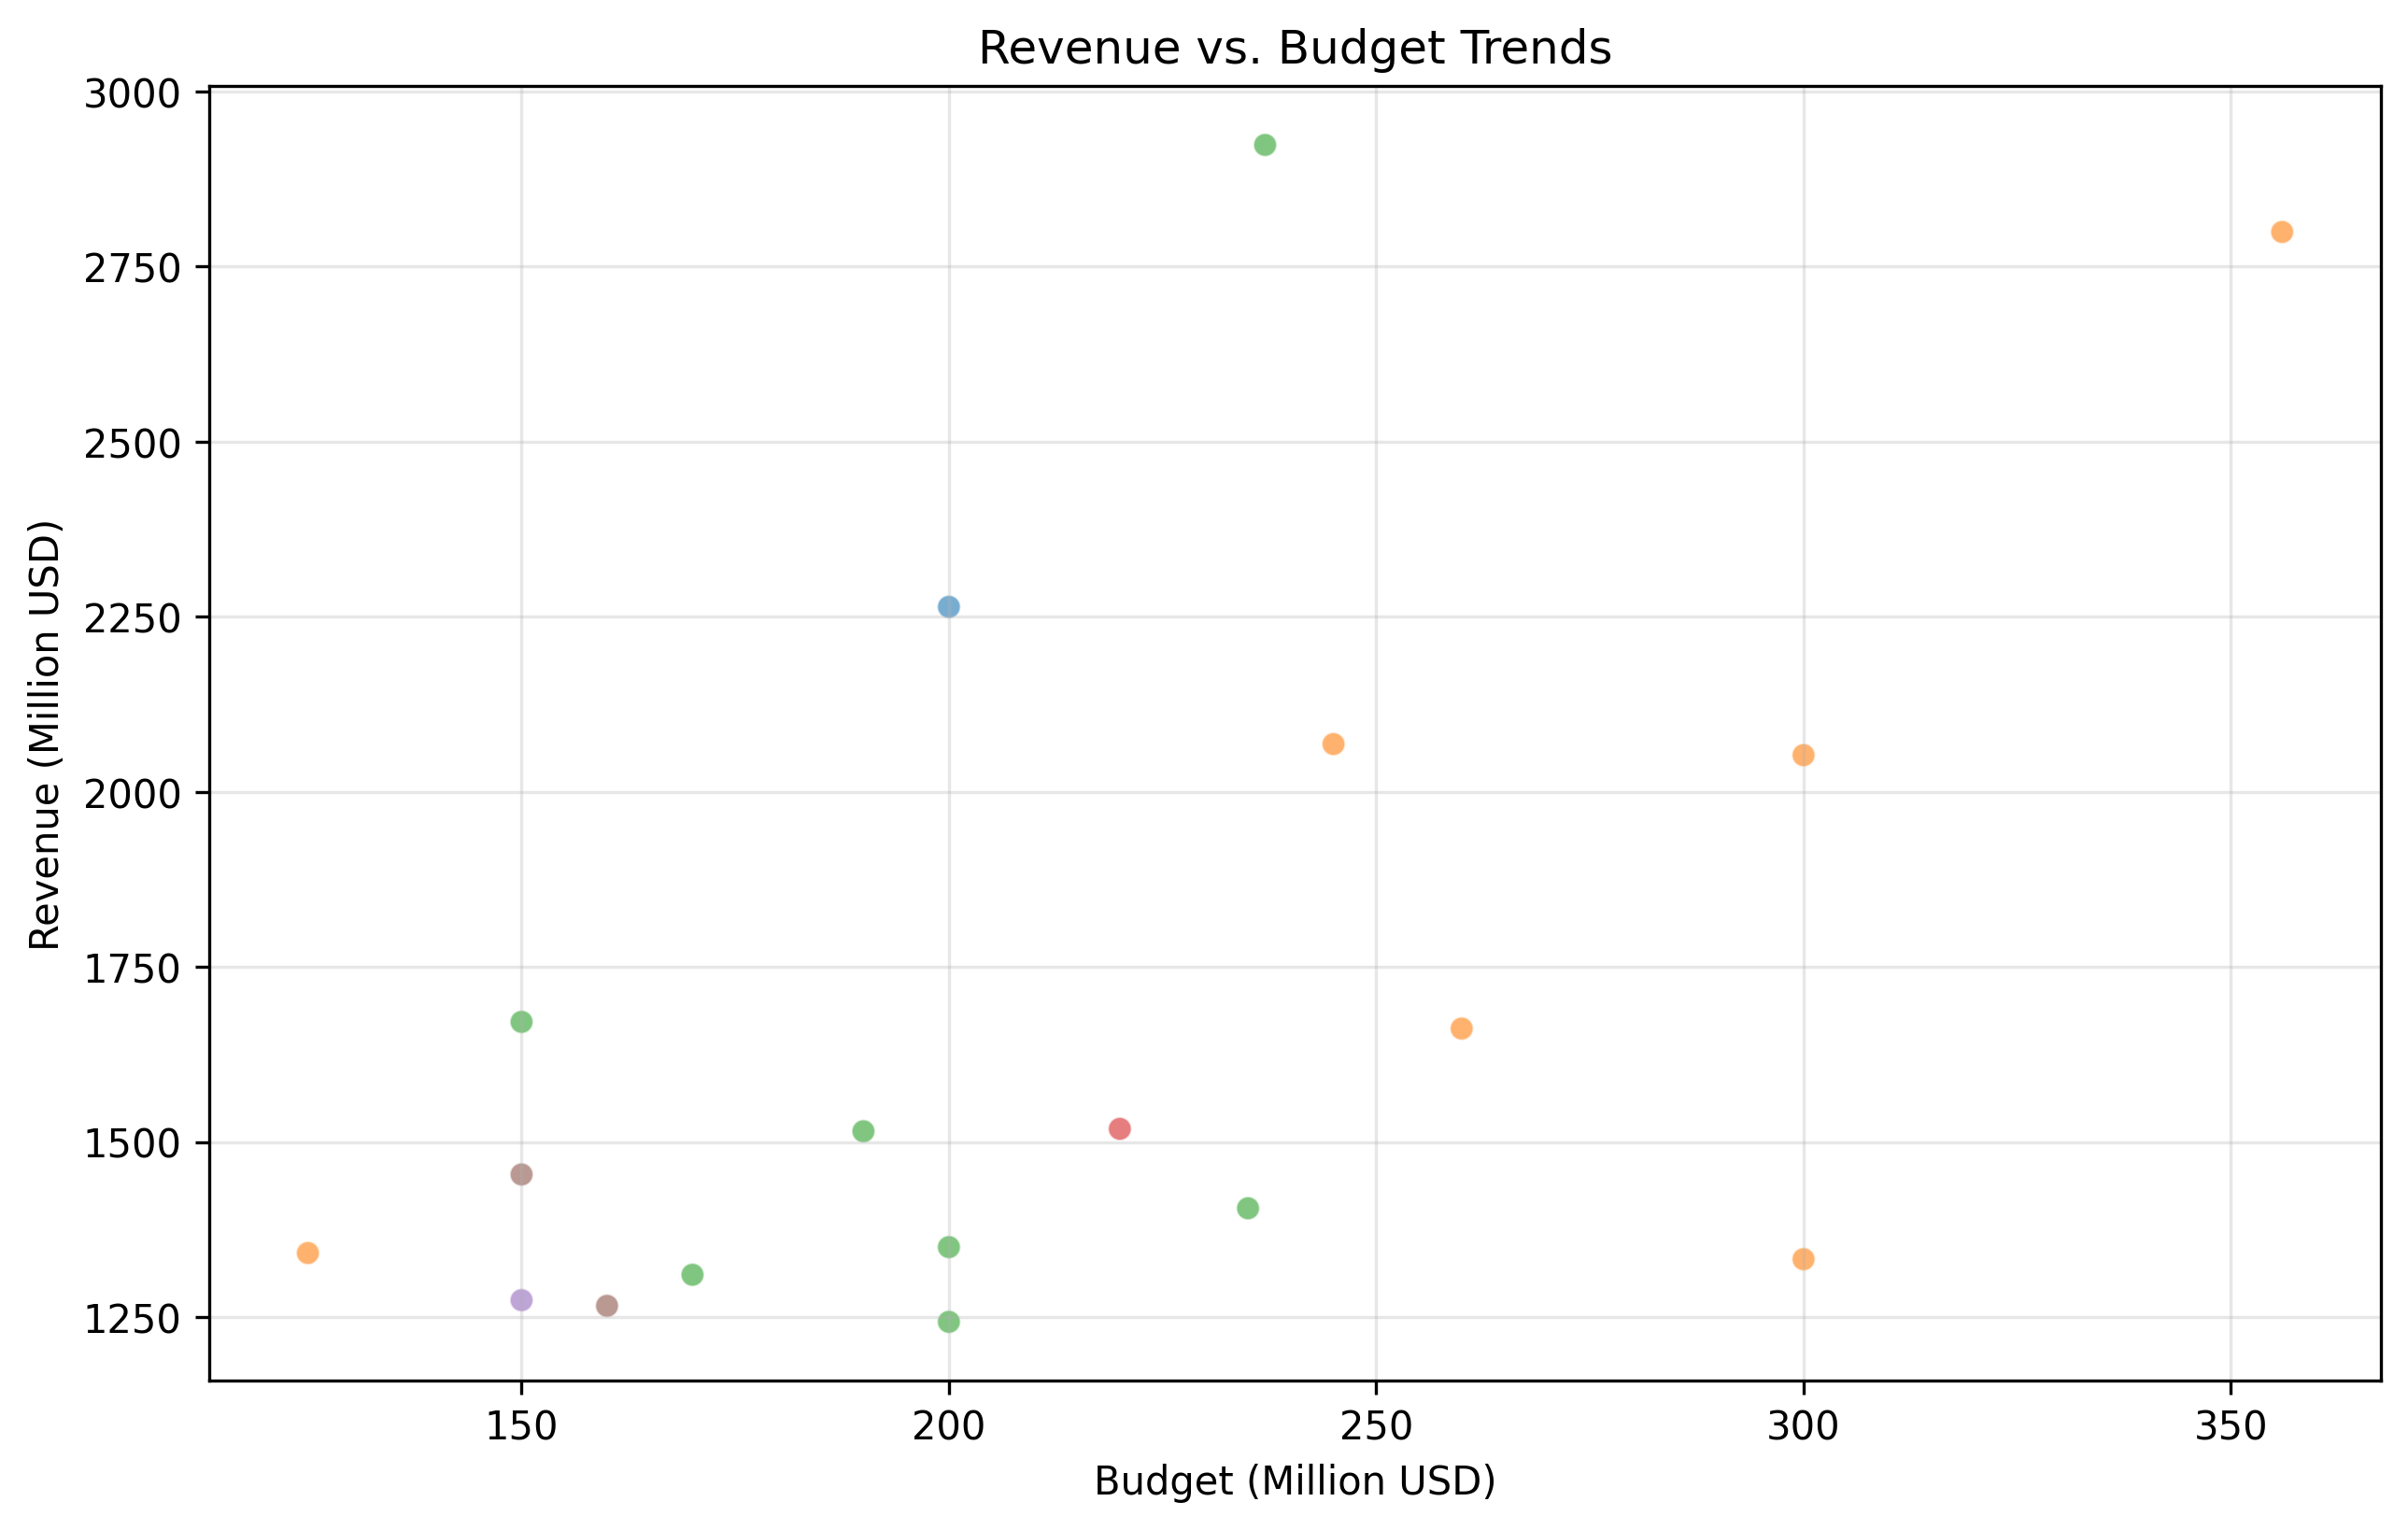

In [14]:
path = visualizer.plot_revenue_vs_budget()
display(Image(filename=path))

Saved plot: plots\Revenue_vs_Budget_Yearly.png


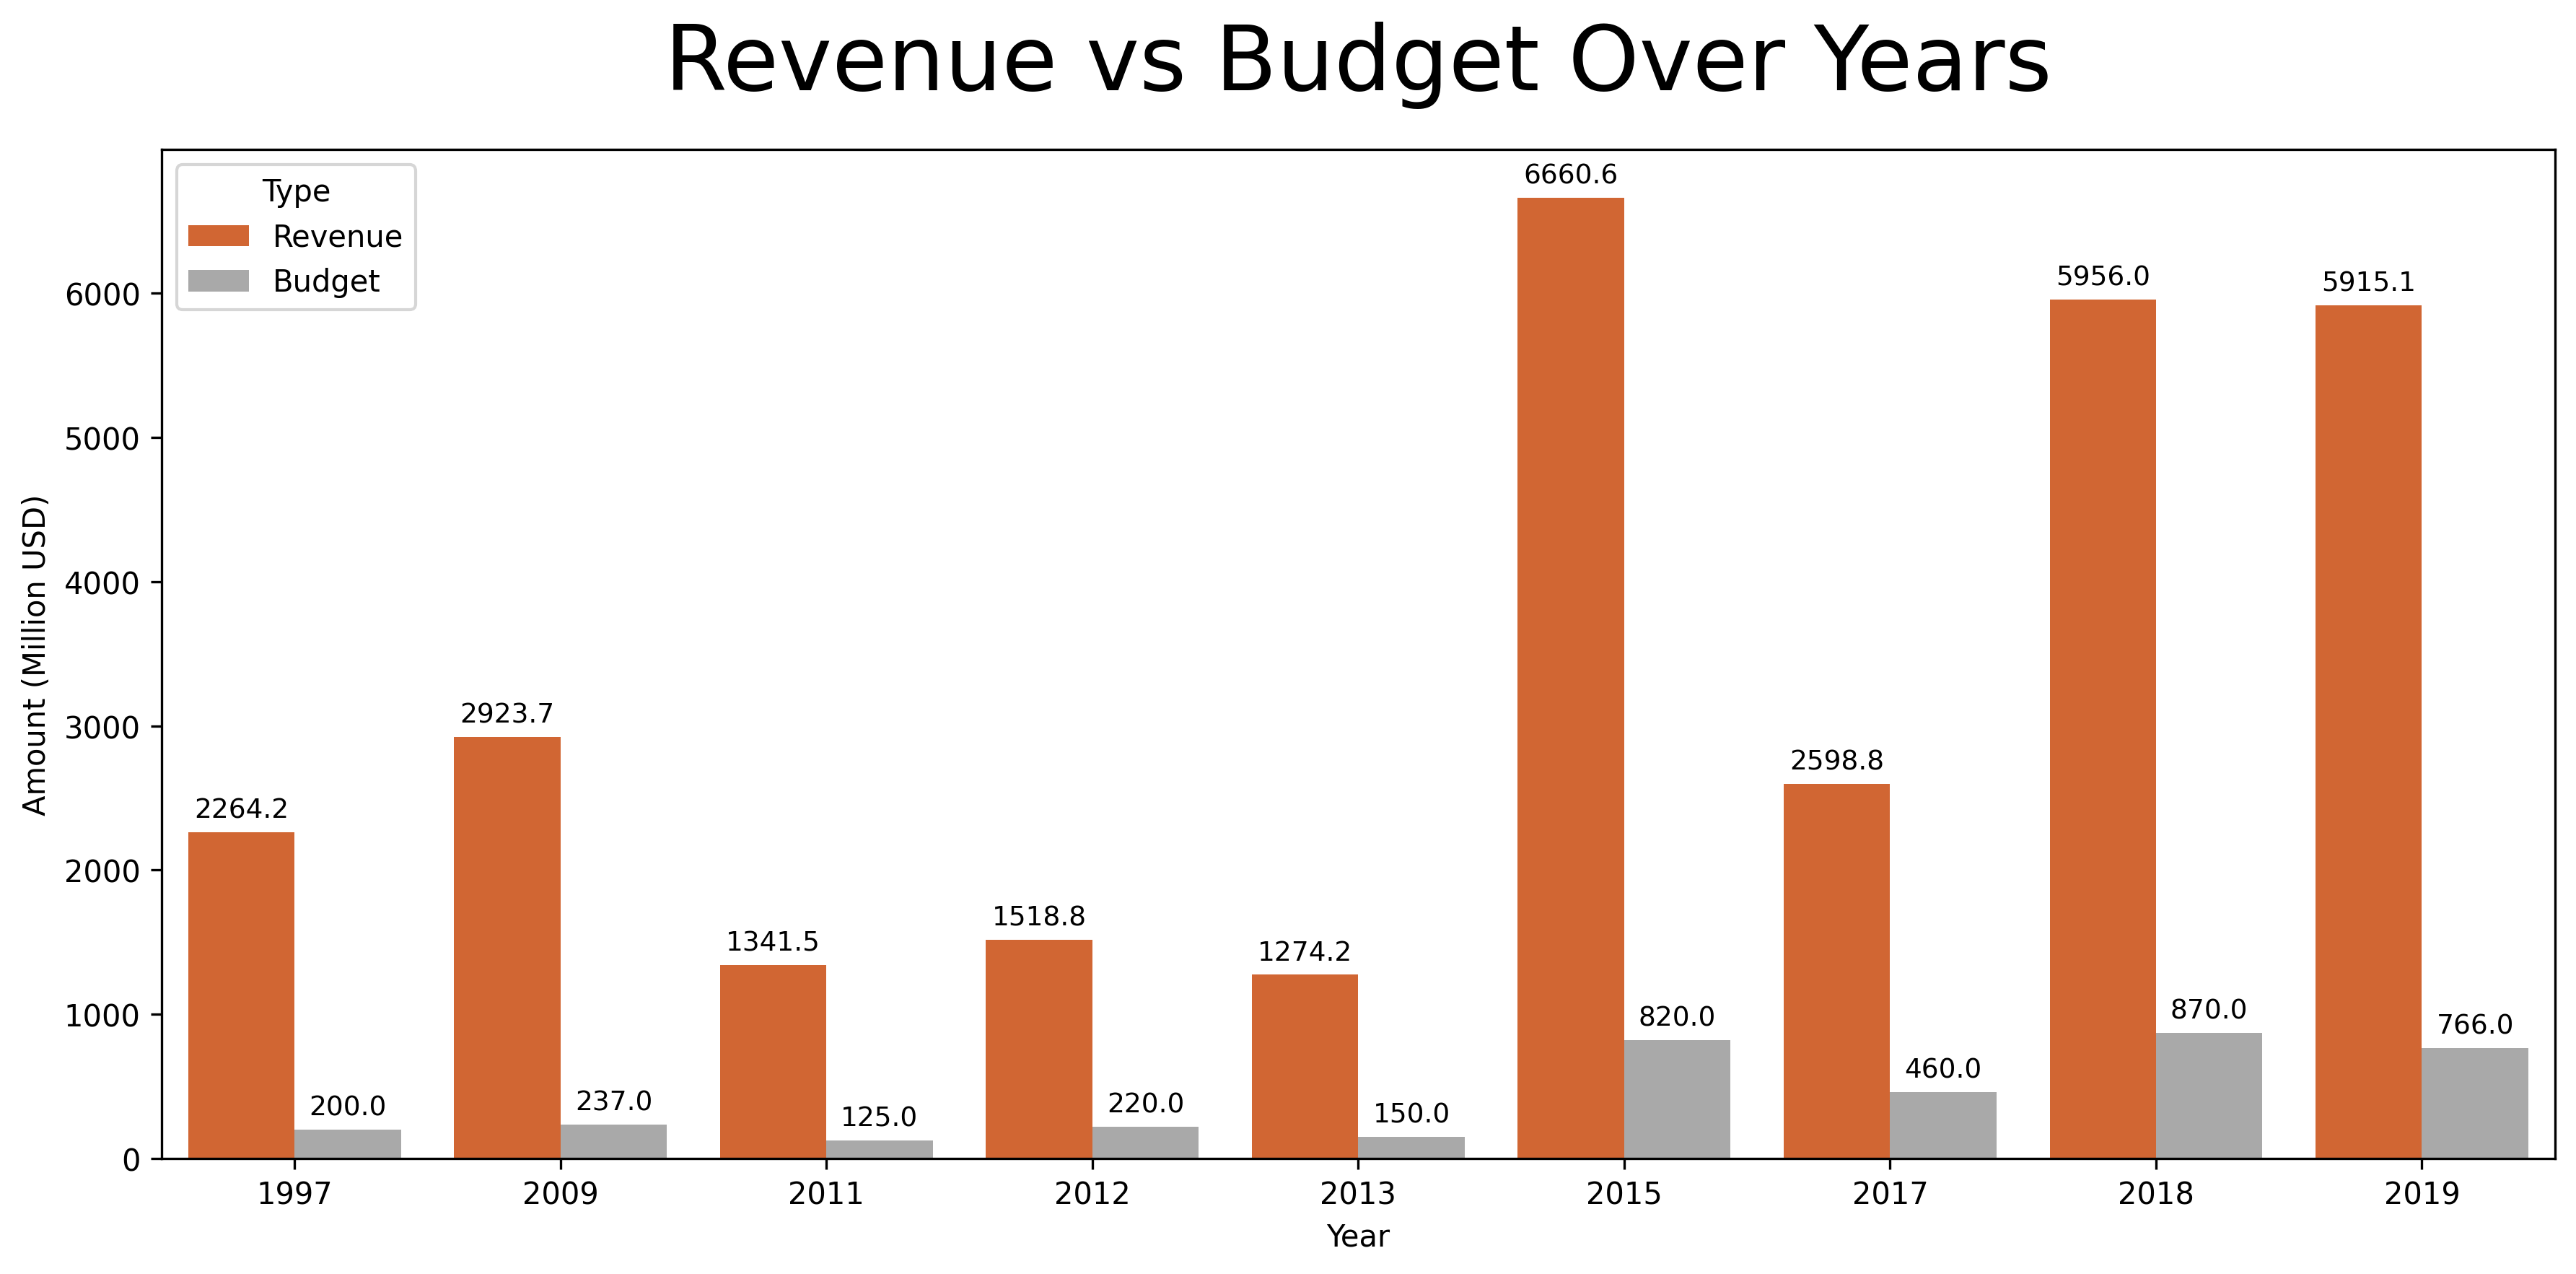

In [32]:
# Revenue vs Budget Over Years
path = visualizer.plot_revenue_vs_budget_yearly()
display(Image(path))

### 4.2 ROI Distribution

Saved plot: plots\ROI_by_Genre.png


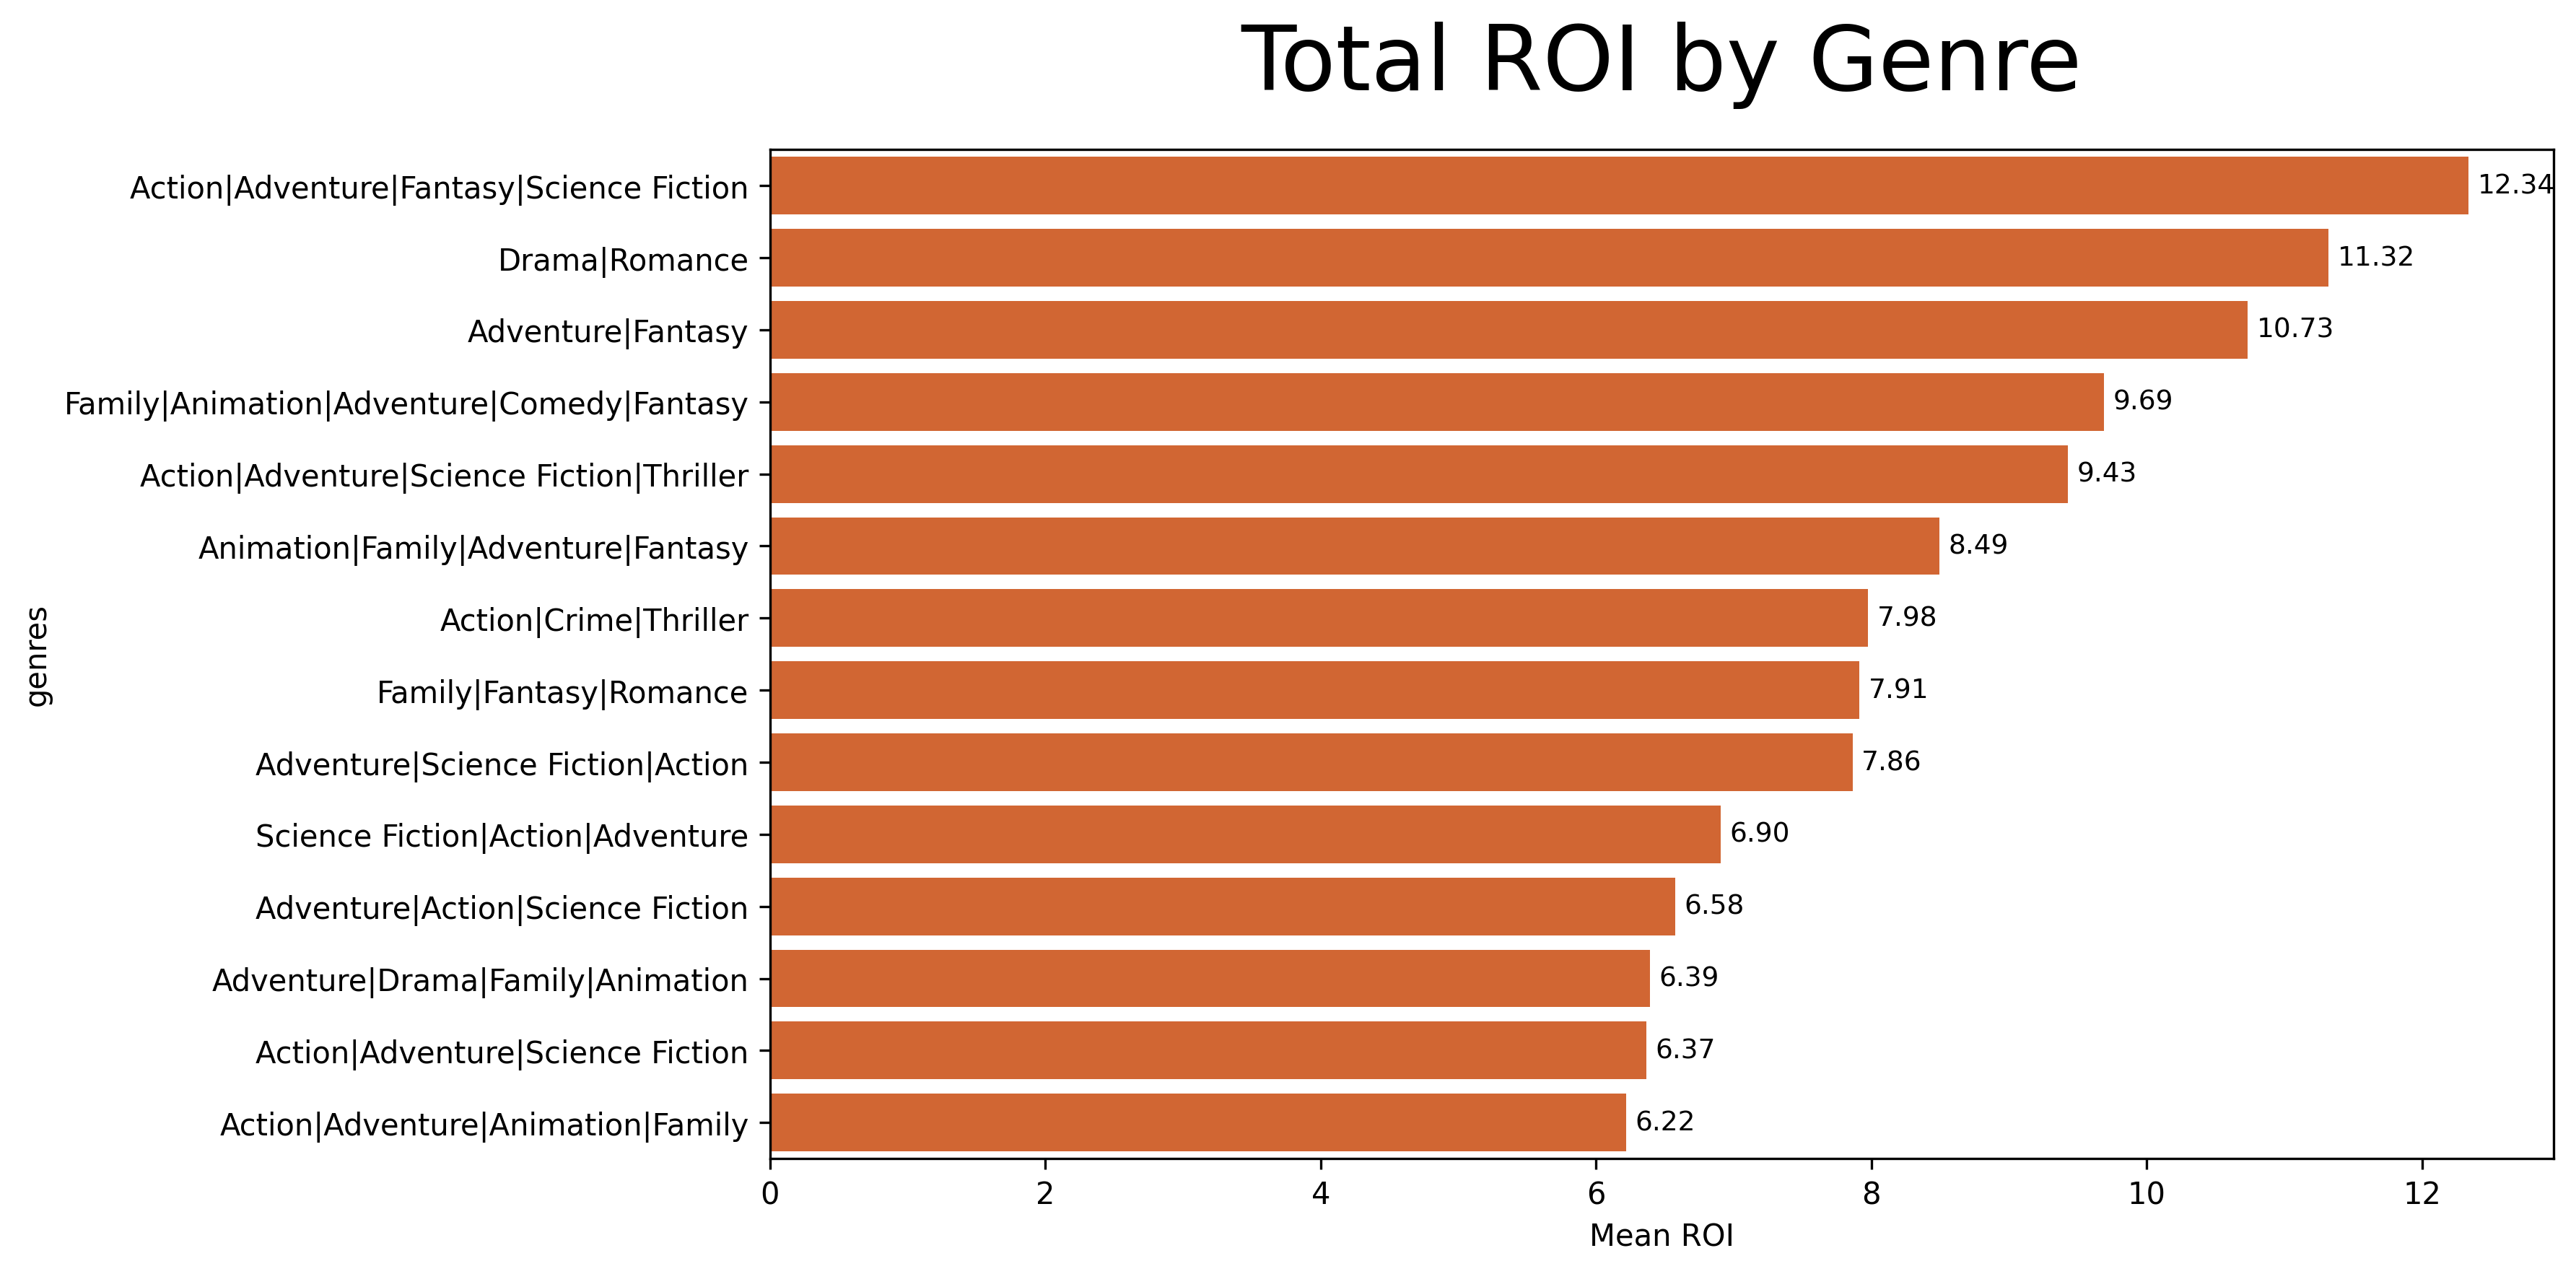

In [33]:
# ROI by Genre
path = visualizer.plot_roi_by_genre()
display(Image(path))

Saved plot: plots\ROI_Distribution_by_Genre.png


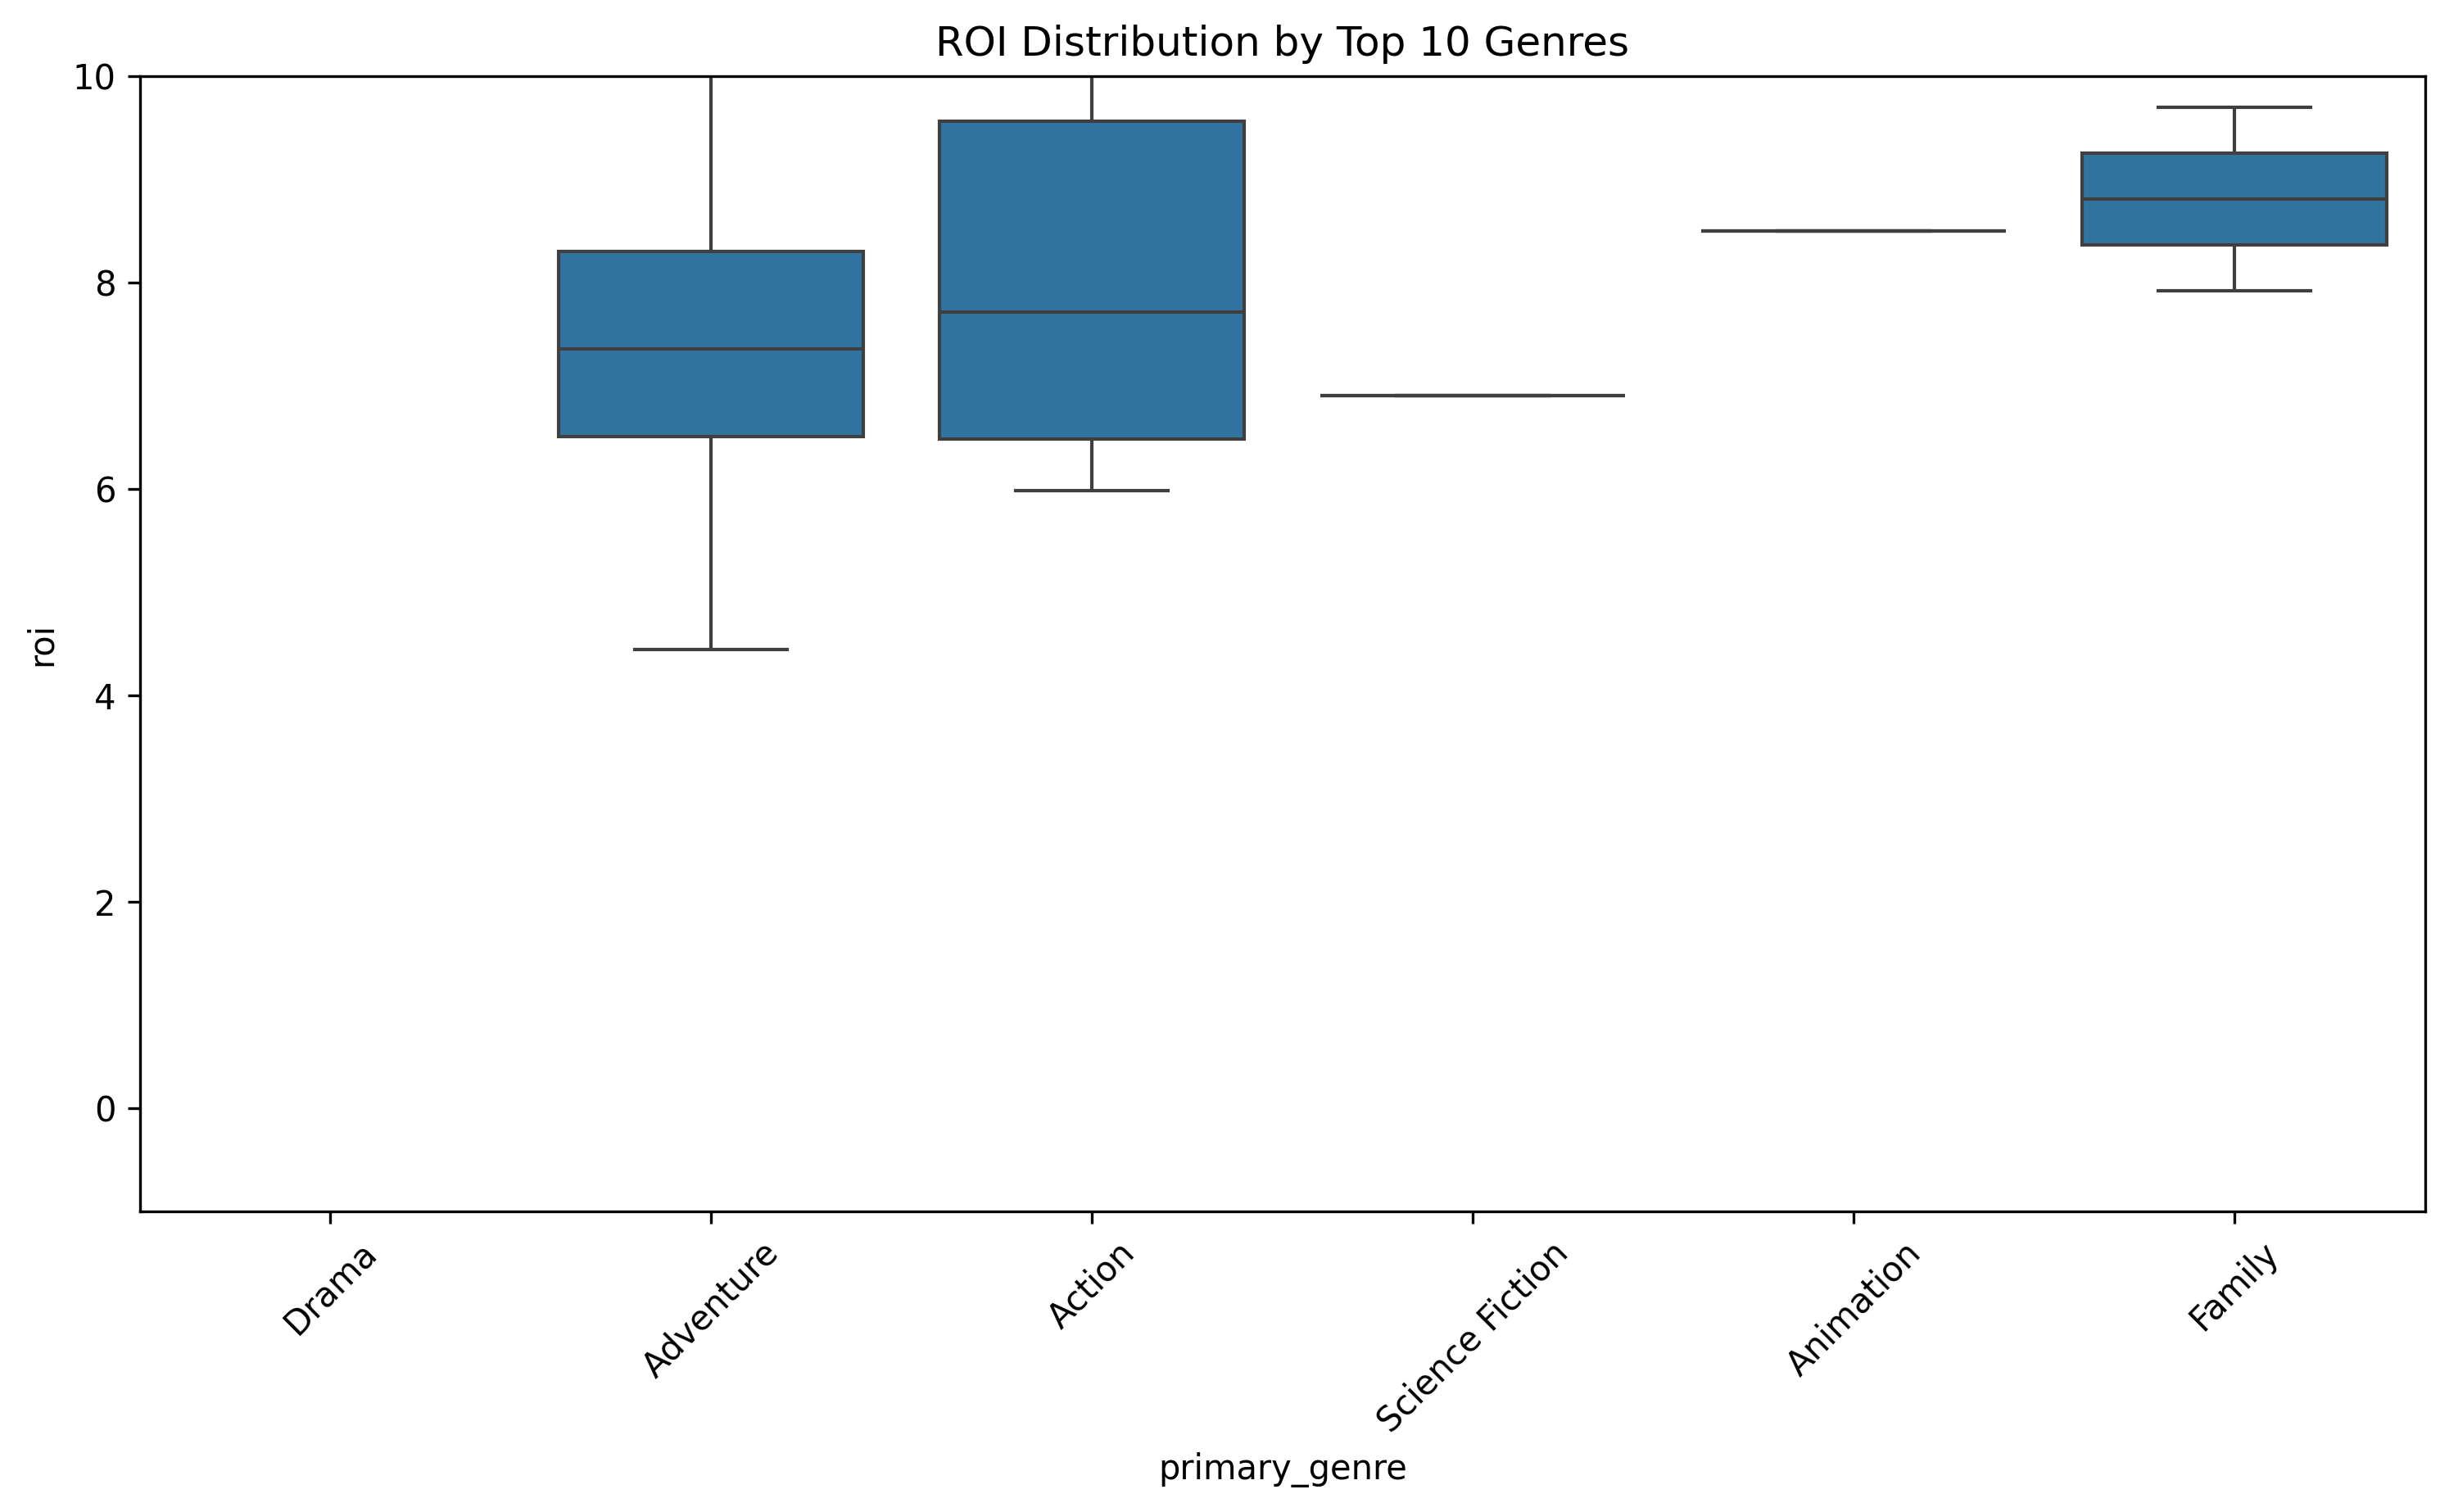

In [27]:
path = visualizer.plot_roi_distribution()
display(Image(filename=path))

### 4.3 Popularity vs Rating

Saved plot: plots\Popularity_vs_Rating.png


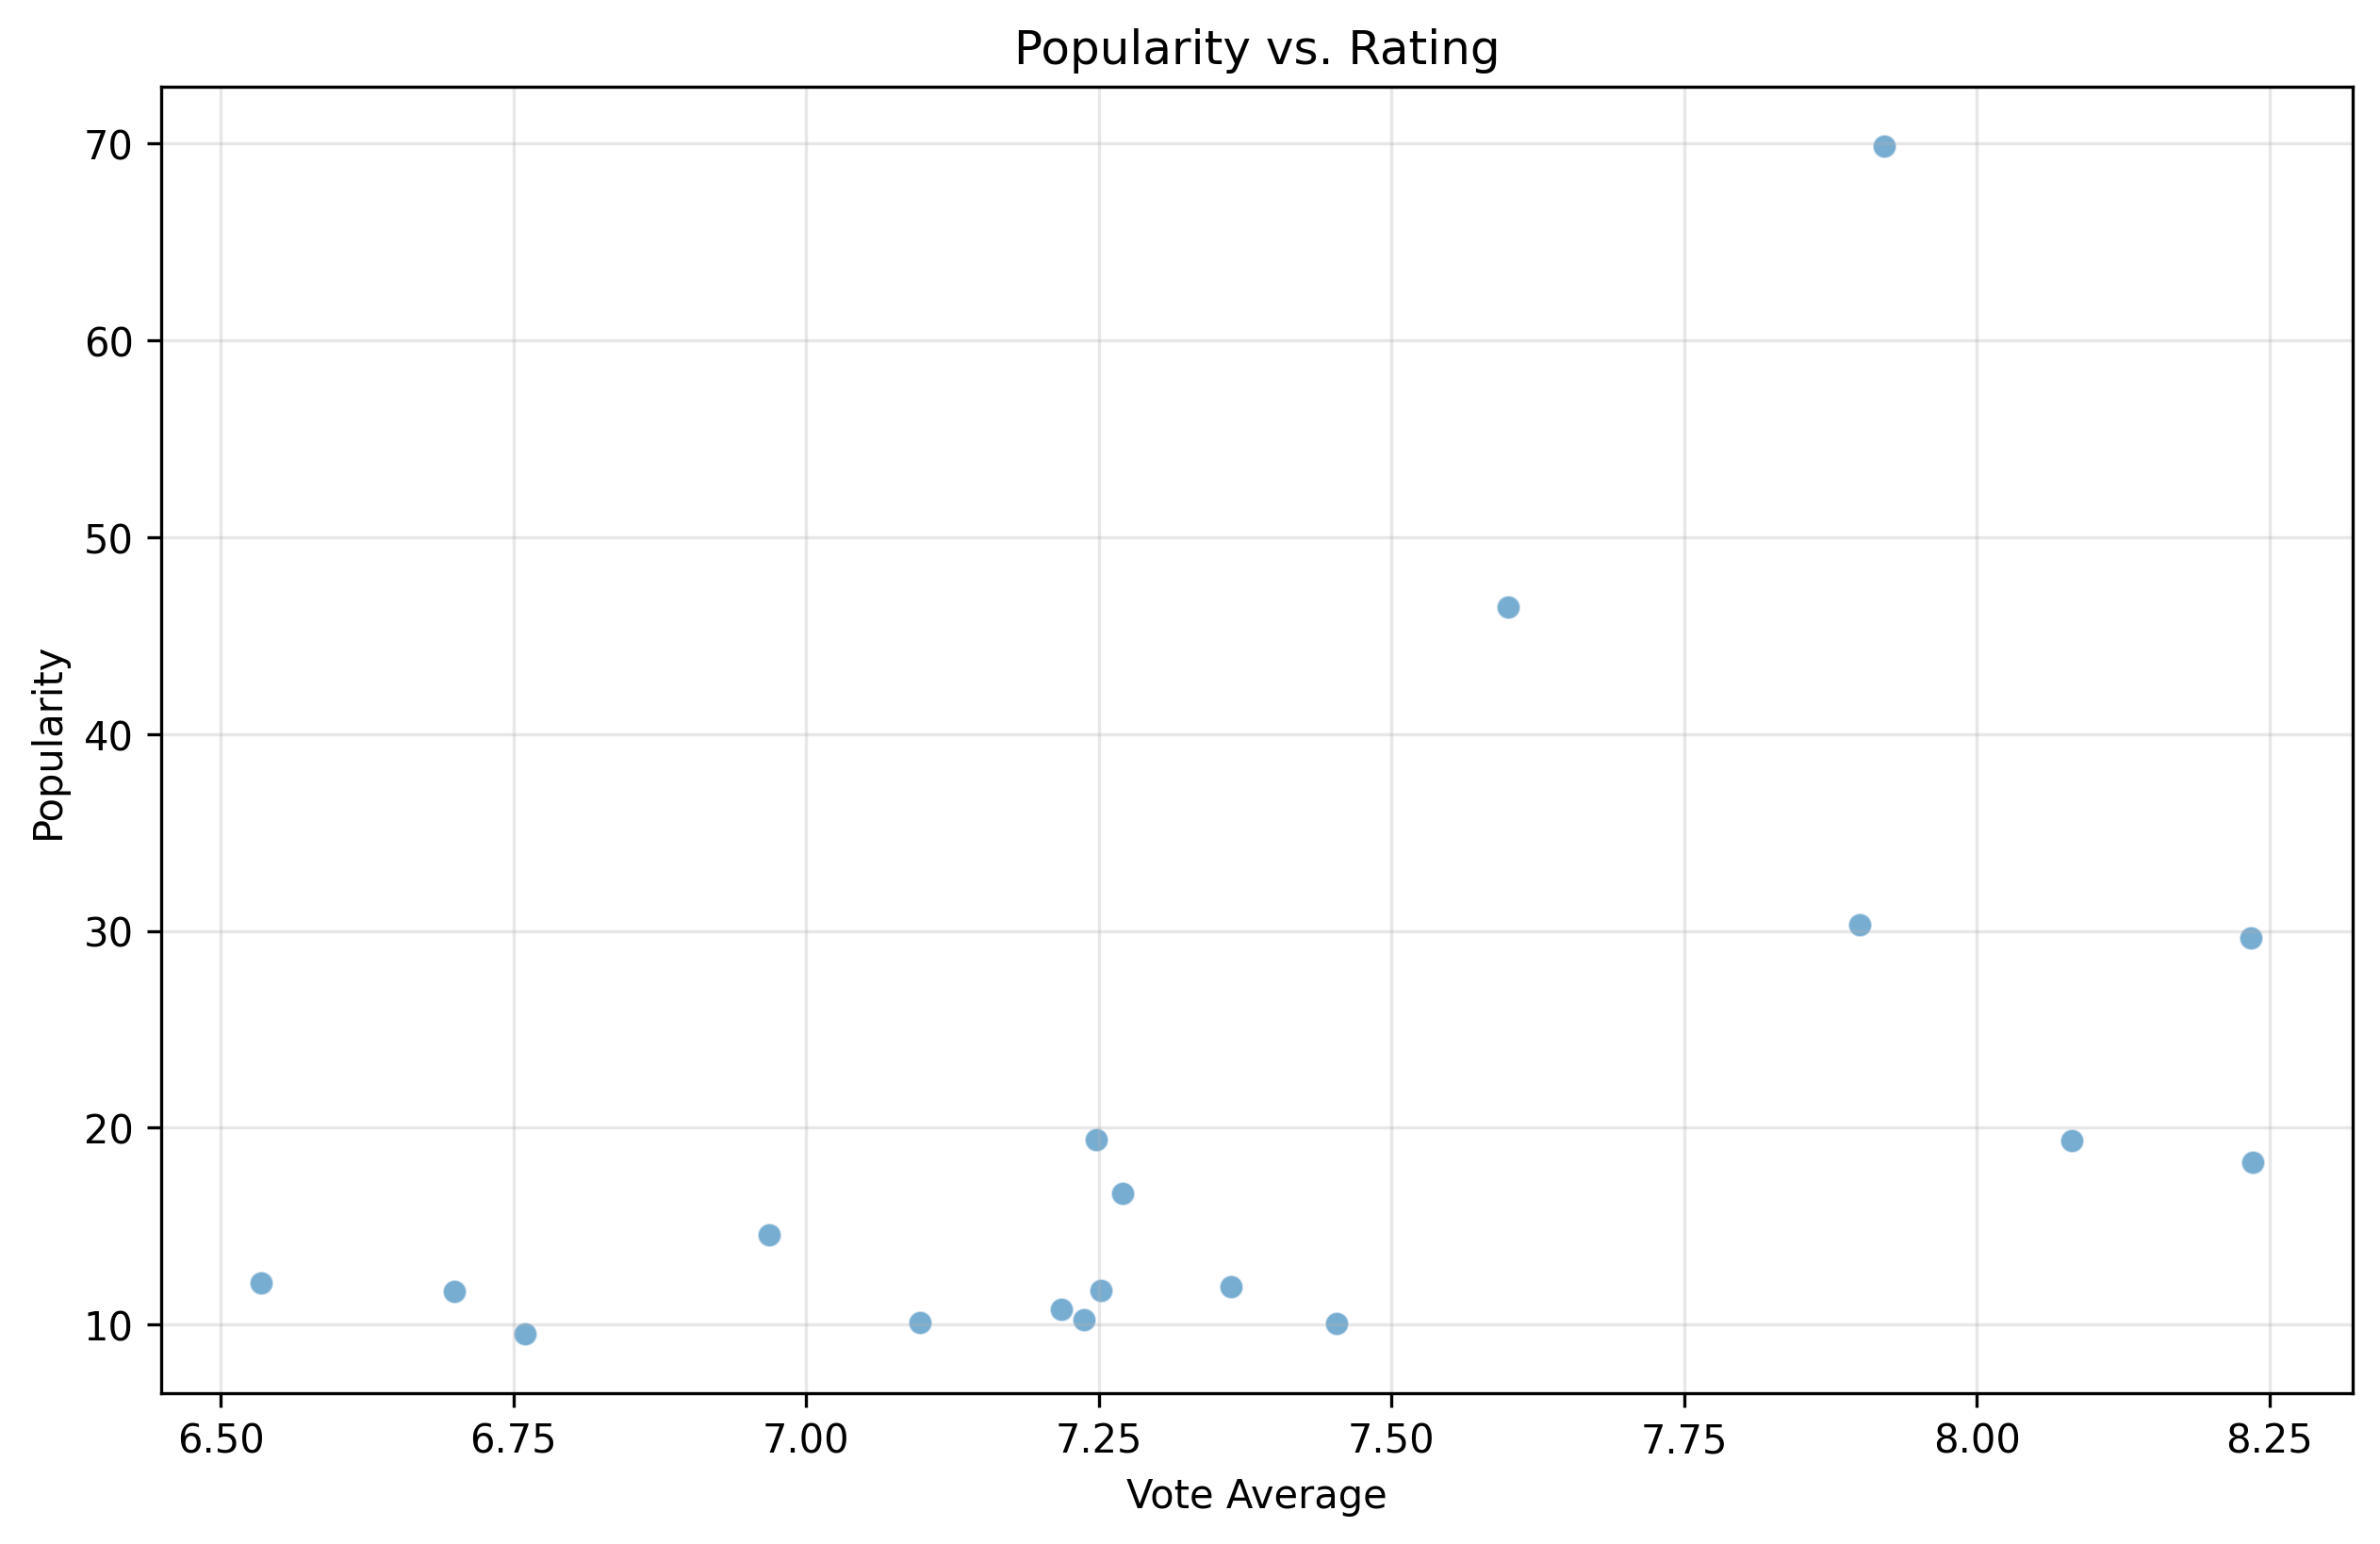

In [16]:
path = visualizer.plot_popularity_vs_rating()
display(Image(filename=path))

### 4.4 Make Detailed Franchise Comparison

Saved plot: plots\Franchise_vs_Standalone.png


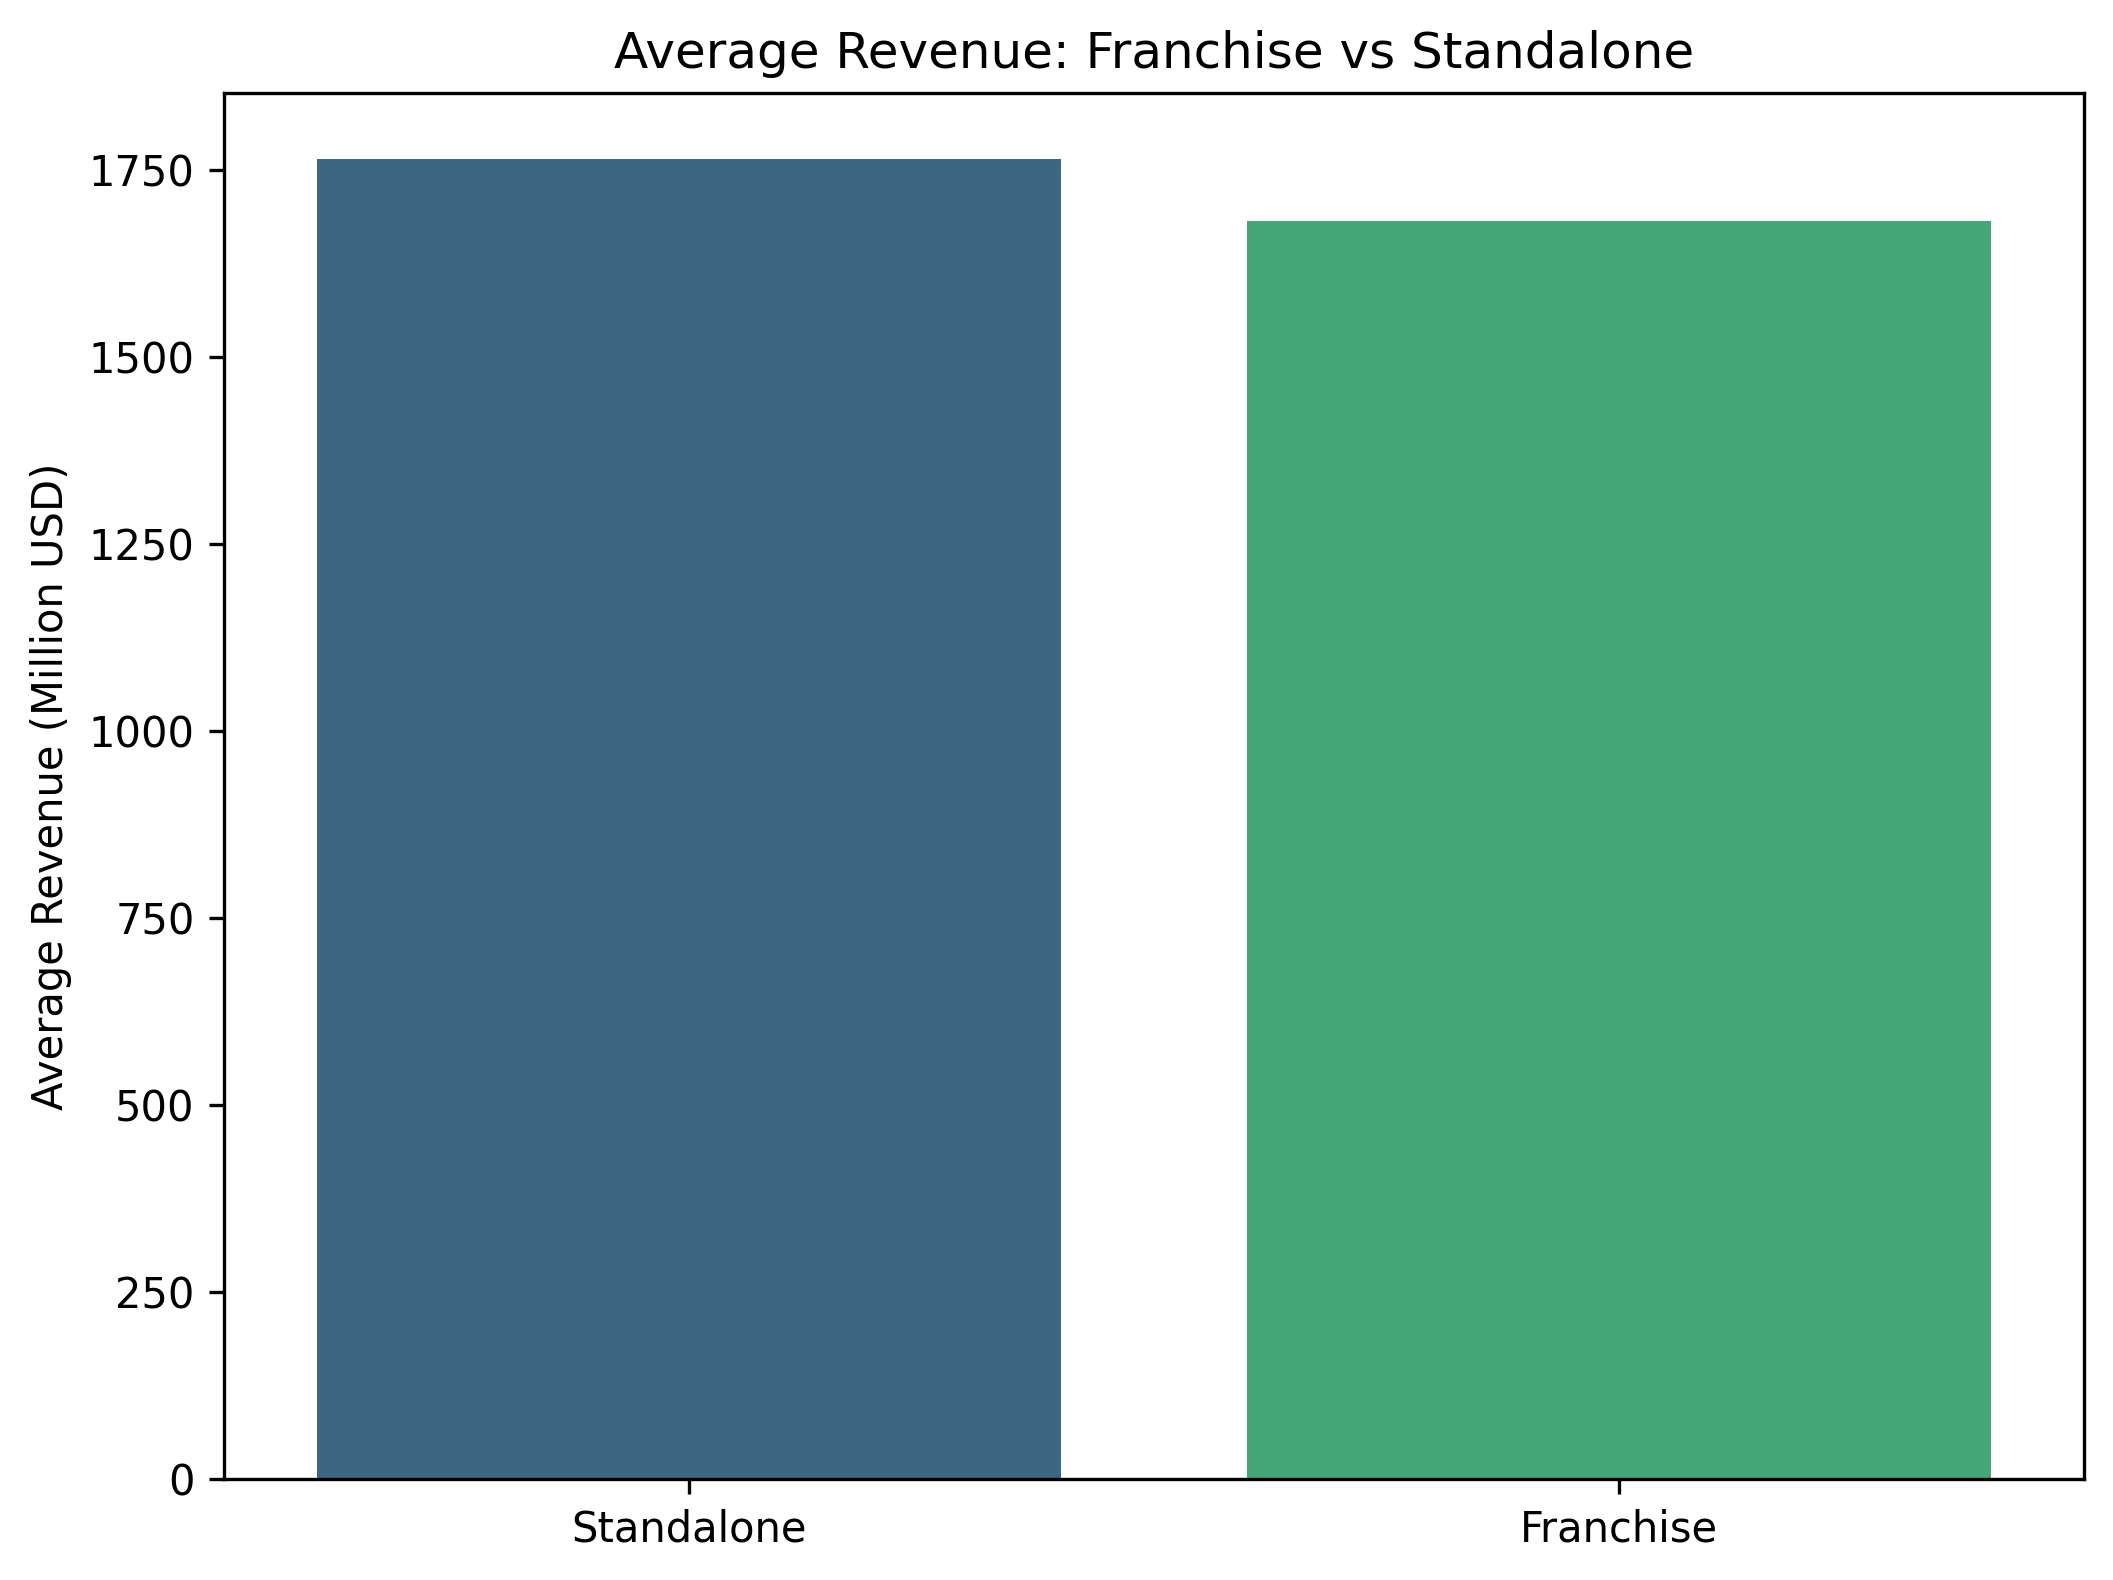

In [28]:
path = visualizer.plot_franchise_comparison()
display(Image(filename=path))